# NFL Redzone Analytics

**By: Isaac Rattey**
---

blah blah blah

---
## Libraries

Here are the libraries we will be using for this project:
- [pandas](https://pandas.pydata.org/): Will allow us to work with the data through tables (Called dataframes).
- [numpy](https://numpy.org/): Helps with computation and numerical analysis so that we don't need to reinvent the wheel. It works well with pandas.
- [matplotlib](https://matplotlib.org/): Allows us to make graphs easily. [Here](https://www.python-graph-gallery.com/) is a website that is a good guide to what matplotlib is capable of.
- [seaborn](https://seaborn.pydata.org/): Also helpful for making graphs. I will be using it to help make some graphs prettier. It works well with matplotlib.
- [scipy](https://www.scipy.org/): Helpful for math. I will be using it for performing a linear regression.
- more . . . . . . . . 


---
## Data Scraping

In order to perform any data science, we first need to collect some data. This can be done in many ways. If the data is already in a downloadable .csv file or database, you can just download that file, and perform any analytics you please. Sometimes you may need to "scape" the data yourself. In those cases, you may need to use the [Requests](https://docs.python-requests.org/en/master/) library and/or [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

For this dataset, we can simply use [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html), since the dataset we are retrieving is already in [.csv format](https://en.wikipedia.org/wiki/Comma-separated_values), and accessible at the URL that I use. The documentation for this data can be found [here](https://github.com/nflverse/nflfastR), and information about how to use it in Python can be found [here](https://github.com/nflverse/nflfastR-data). I referred to this documentation when writing the code below.

For the purposes of this tutorial, I will be pulling the play-by-play data for only the 2020-2021 NFL season.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# This code scapes the play-by-play data for the 2020-2021 season
# In this URL, we could replace 2020 with another year in order to scape the play-by-play data for that season
data = pd.read_csv('https://github.com/nflverse/nflfastR-data/blob/master/data/play_by_play_2020.csv.gz?raw=True', compression='gzip',low_memory=False)

# Print out the total number of rows and columns in the dataset:
print(f"Columns: {len(data.columns)}")
print(f"Rows: {len(data)}")

Columns: 370
Rows: 48514


---
## Data Management and Cleaning

This dataset has a ton of rows (over 48,000), and columns (almost 400!!), so there is a lot of data to wade through. We could try to deduce what each column means ourselves, however the documentation for this dataset includes a description of what data each column contains. A description of the purpose of each column can be found [here](https://www.nflfastr.com/articles/field_descriptions.html).

Since we are interested in studying the redzone, we can restrict our data by only looking at rows where the offense has 20 or fewer yards to go. In order to do this, we need to find a column that helps us make this distinction. By examining the [documentation](https://www.nflfastr.com/articles/field_descriptions.html), we can see that there is a column titled `yardline_100`, which is described as the "Numeric distance in the number of yards from the opponent's endzone for the posteam." where the "posteam" is shorthand for the team that is in possession of the football at the beginning of the play. With this in mind, we can execute the following code to limit our dataset to only plays where the offense(possesion team) is in the red zone.

In [2]:
# Update the dataset to only include rows where the possesion team has fewer than 20 yards to go.
data = data[data.yardline_100 <= 20]

# Print the new length of the dataset
print(f"Rows: {len(data)}")

Rows: 7819


After updating our dataset, we have gone from 48,514 plays down to just 7,819 plays.

---
## Exploratory Data Analysis

The Exploratory Data Analysis portion of the data science pipeline involves messing around and looking for trends in the data.

I will start by looking at the overall distribution of pass vs run plays that the offense runs in the red zone. To do this, I will be using the `play_type` column to distinguish between run plays, pass plays, and other plays (includes field goals, extra points, etc.). To start, we should first figure out how many plays of each type exist in this dataset. We can do this by using the [`value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) function that is included with pandas.

In [3]:
data.play_type.value_counts()

pass           2837
run            2612
extra_point    1372
field_goal      489
no_play         409
qb_kneel         52
kickoff          29
qb_spike         19
Name: play_type, dtype: int64

So our other category includes extra points, field goals, and other plays that are common in the red zone. It makes sense that the plurality of these plays are runs and passes, but we are also including extra points, qb kneels, and other plays that are not relevant to our analysis of red zone offense. One strange value in this column is the `no_play` play type. The [documentation](https://www.nflfastr.com/articles/field_descriptions.html) for the `play_type` column says that `no_play` includes  "timeouts and penalties".

According to the documentation, the `two_point_attempt` column is a "Binary indicator for two point conversion attempt", so we also need to drop any rows where that is the case.

With this in mind, since we are only interested in offensive plays, we can safely drop all of the plays that are not `run` or `pass` plays:

In [4]:
# Keep only plays where the play_type is pass or run
data = data[((data.play_type == "pass") | (data.play_type == "run")) & (data.two_point_attempt == 0)]

# Verify that we only have pass and run plays now
data.play_type.value_counts()

pass    2736
run     2573
Name: play_type, dtype: int64

Now we are only including pass and run plays! We can continue with our basic analysis of how many run and pass plays are called in the red zone:

In [5]:
# Collect abbreviations for the different teams
allTeams = set(data.home_team)

# To make things easier in the future, we can make a new dataframe containing team statistics
teamData = pd.DataFrame(index=allTeams)

# Make some empty columns
teamData["numRun"] = 0
teamData["numPass"] = 0
teamData["totalPlays"] = 0

# Count up the number of run, pass, and other types of plays for each team
for team in allTeams:
    for index, val in data[data.posteam == team].iterrows():
        if val.play_type == 'pass':
            teamData.loc[team].numPass += 1
        elif val.play_type == 'run':
            teamData.loc[team].numRun += 1
        teamData.loc[team].totalPlays += 1

# Sort by total number of plays from highest to lowest
teamData = teamData.sort_values(by=['totalPlays'], ascending=False)

# Print the data
teamData

,numRun,numPass,totalPlays
NO,120,101,221
BUF,86,119,205
TB,78,122,200
KC,76,119,195
GB,93,101,194
IND,97,96,193
LV,100,89,189
CLE,102,86,188
BAL,108,76,184
MIN,106,73,179


Now we have basic counts of how many pass plays and run plays each team made in the red zone during the 2020-2021 season, but it is very unintuitive to read this way. In the next section, we will visualize this data.

---
## Plotting

Plotting is part of the Exploratory Data Analysis and Communication portions of the data science pipeline. It is important because large data sets are hard to visualize and make conclusions from. By plotting the data, we make it easier to intuitively see the trends in the data

In order to plot this data, we will be using [Matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/). Both of these libraries provide very simple and intuitive methods for making many types of plots. We will start by plotting the data we just collected about the distributions of run plays and pass plays in the red zone.

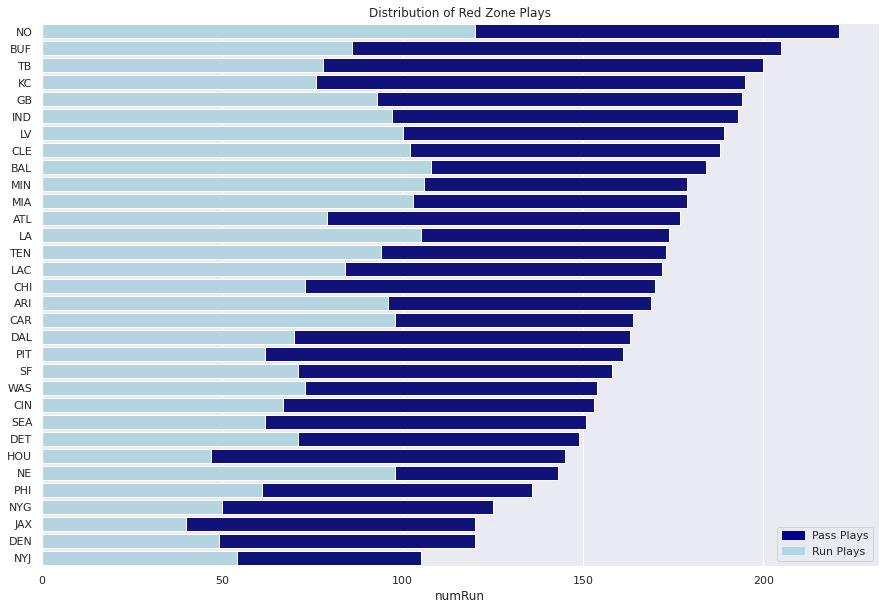

In [6]:
# Import necessary libraries
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Stylize as dark
sn.set(style="darkgrid")

# Make the plot
fig, ax = plt.subplots()

bars1 = sn.barplot(x="totalPlays", y=teamData.index, data=teamData, color="darkblue")
bars2 = sn.barplot(x="numRun", y=teamData.index, data=teamData, color="lightblue")

# Style
ax.set_title('Distribution of Red Zone Plays')

# Legend
right_bar = mpatches.Patch(color='darkblue', label='Pass Plays')
left_bar = mpatches.Patch(color='lightblue', label='Run Plays')
plt.legend(handles=[right_bar, left_bar])

fig.set_figwidth(15)
fig.set_figheight(10)

This graph gives us a good visualization of the types of plays teams tend to run in the red zone, however, the fact that different teams have run different amounts of plays in the red zone makes it difficult to see the distribution. We can make this a little easier by converting to percentages and re-plotting the data.

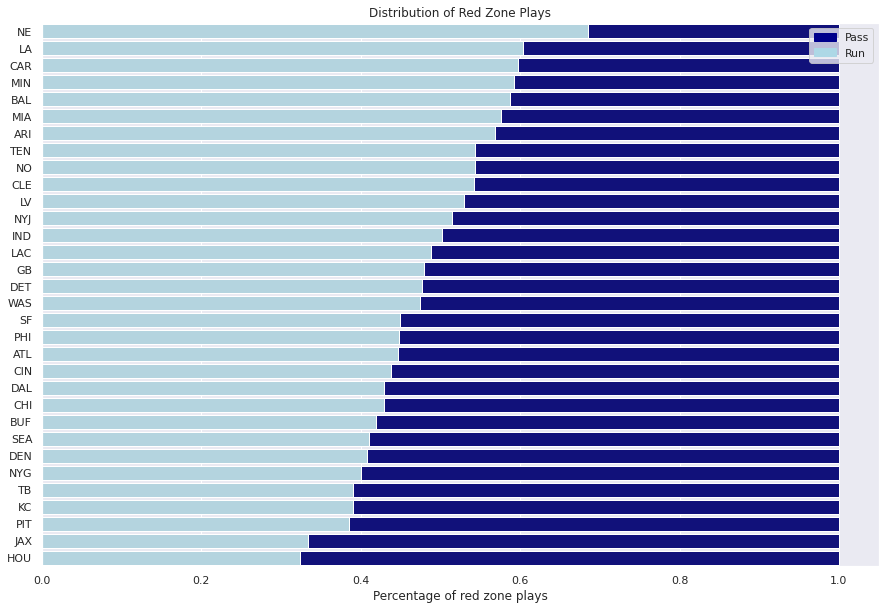

In [7]:
# Calculate the percentage of pass plays, run plays, and other types of plays for each team
# We need percentages because teams did not run the same number of plays from inside the red zone
teamData["percPass"] = teamData.numPass / teamData.totalPlays
teamData["percRun"] = teamData.numRun / teamData.totalPlays

# Now we can re-sort based on percentage of run plays
teamData = teamData.sort_values(by=['percRun'], ascending=False)

# Now we can re-plot this data
fig, ax = plt.subplots()

teamData["ones"] = 1
bars1 = sn.barplot(x="ones", y=teamData.index, data=teamData, color="darkblue")
bars2 = sn.barplot(x="percRun", y=teamData.index, data=teamData, color="lightblue")
teamData.drop(["ones"], axis=1)

# Style
ax.set_title('Distribution of Red Zone Plays')

# Legend
right_bar = mpatches.Patch(color='darkblue', label='Pass')
left_bar = mpatches.Patch(color='lightblue', label='Run')
plt.legend(handles=[right_bar, left_bar], loc=1)
ax.set_xlabel('Percentage of red zone plays')

fig.set_figwidth(15)
fig.set_figheight(10)

This data is a bit easier to process. We can see which teams prefer running versus passing the football in the redzone.

While this data is interesting, it is not super useful on its own. The red zone is a range of 20 yards, so we may want to break this dataset down based on how far from the redzone the offense is. First lets see how many samples we have for each yard line:

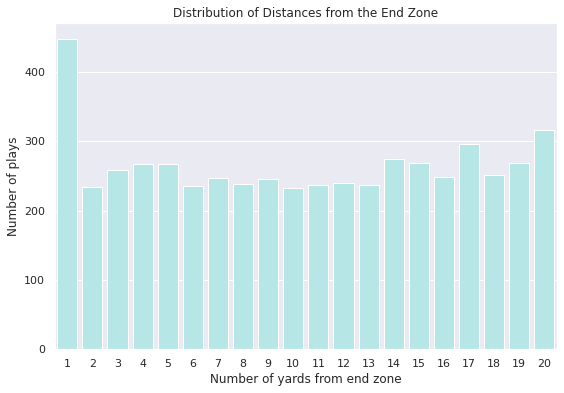

In [8]:
numPlays = data.yardline_100.value_counts().sort_index()

# Lets plot it
fig, ax = plt.subplots()

# Using a list comprehension to convert the yard lines to integers
bars1 = sn.barplot(x=[int(i) for i in numPlays.index], y=numPlays, color="paleturquoise")

# Style
ax.set_title('Distribution of Distances from the End Zone')
ax.set_xlabel('Number of yards from end zone')
ax.set_ylabel('Number of plays')

fig.set_figwidth(9)
fig.set_figheight(6)

So we have a fair amount of data for all distances. We have significantly more data for the 1 yard line, however we have around 250 data points for all of the other distances.

Let's see what the probablility we have of scoring a touchdown from each distance on a given play. If we are able to find a trend, we may be able to attempt to predict a success rate. In order to do this, we will be using the `touchdown` column, which, from the documentation, is a "Binary indicator for if the play resulted in a TD."

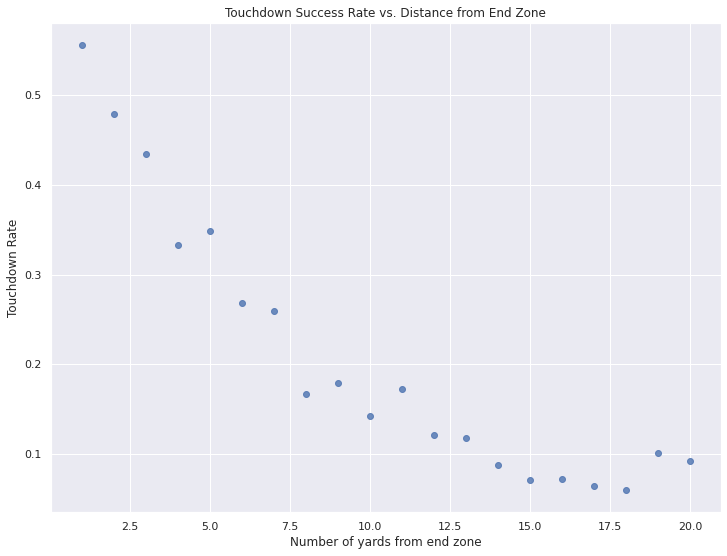

In [9]:
# Let's make yet another dataframe for storing data based on distance
distanceData = pd.DataFrame(index=[int(i) for i in numPlays.index], data = numPlays)
distanceData = distanceData.rename(columns={"yardline_100":"numPlays"})

# Make columns for success rates
distanceData["success"] = 0
distanceData["total"] = 0

# Get a success rate for each distance
for distance in distanceData.index:
    for index, val in data[data.yardline_100 == distance].iterrows():
        distanceData.loc[distance].total += 1
        if val.touchdown == 1:
            distanceData.loc[distance].success += 1

# Calculate the percentage
distanceData["successRate"] = distanceData.success/distanceData.total

# Now make a scatter plot
fig, ax = plt.subplots()

sn.regplot(x=distanceData.index, y=distanceData.successRate, fit_reg = False)

# Style
ax.set_title('Touchdown Success Rate vs. Distance from End Zone')
ax.set_xlabel('Number of yards from end zone')
ax.set_ylabel('Touchdown Rate')

fig.set_figwidth(12)
fig.set_figheight(9)

As we can see, touchdown rate tends to decrease as the distance from the endzone increases, which makes sense. It appears close to linear, but it is fuzzy, and could also be polynomial. We will explore this further, but for now, we can plot a linear regression line just to see what it would look like:

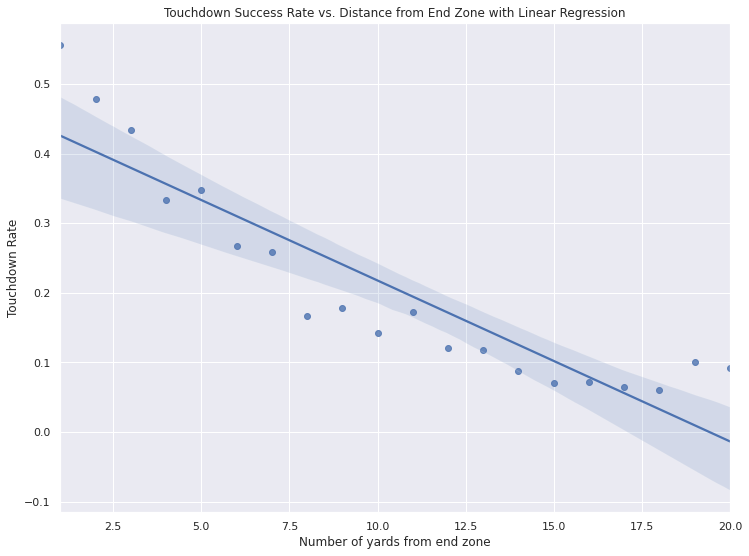

In [10]:
# Plot with regression line
fig, ax = plt.subplots()
sn.regplot(x=distanceData.index, y=distanceData.successRate)

# Style
ax.set_title('Touchdown Success Rate vs. Distance from End Zone with Linear Regression')
ax.set_xlabel('Number of yards from end zone')
ax.set_ylabel('Touchdown Rate')

fig.set_figwidth(12)
fig.set_figheight(9)

---
## Hypothesis Testing

In order to figure out whether there is a linear relationship between touchdown rate and the distance from the end zone in the red zone, we can use a hypothesis test. A [hypothesis test](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) comes from statistics, and it provides us with a mathematical means for determining whether we can make a conclusion about the data. The basic idea for conducting a hypothesis test, is that we will assume a null hypothesis (this is the opposite of what we want to conclude about the data), and attempt to disprove it. If we are able to disprove the null hypothesis, we will accept the alternate hypothesis, which is the direct opposite of the null hypothesis.

For this hypothesis test, we are hoping to conclude that there is a linear relationship between the number of yards from the end zone, and the touchdown rate. This means that this should be our alternate hypothesis. Therefore, our null hypothesis should be that there is **NOT** a linear relationship between the number of yards from the end zone, and the touchdown rate.

We also need to set a significance level. When we perform the hypothesis test, we will get an output in the form of a p-value. This p-value tells us the **probability** of seeing results as significant as these **if** our null hypothesis is correct. A low p-value means that it is **unlikely** that our null hypothesis is correct. If this is the case, we will **reject the null hypothesis**, and accept the alternate hypothesis. For this test, we will use a p-value of 5%. This means that we have a 5% percent chance of incorrectly rejecting the null hypothesis (this is called a [Type I Error, or a false positive](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)). This 5% probability of a false positive would be too high for some higher stakes statistics, but it is fine for this data analysis.

In summary:
- Null Hypothesis: There is **NO** linear relationship between touchdown rate and distance from the end zone
- Alternate Hypothesis: There **IS** a linear relationship between touchdown rate and distance from the end zone
- Significance Level = 5%

In order to perform this hypothesis test, we will be using [scipy's linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function in order to both calculate the regression line equation, as well as perform the hypothesis test.

In [11]:
# Import necessary libraries
from scipy import stats

# Perform the hypothesis test
slope, intercept, r_value, p_value, std_err = stats.linregress(distanceData.index,distanceData.successRate)

# Print the regression equation
print(f"Touchdown Rate = {round(intercept, 2)} + {round(slope, 3)} * Distance to End Zone")

# Hypothesis test outputs
print(f"R-Squared = {round(r_value**2, 3)}")
print(f"P-Value = {p_value}")
print(f"Std. Error = {round(std_err, 3)}")

Touchdown Rate = 0.45 + -0.023 * Distance to End Zone
R-Squared = 0.827
P-Value = 2.8016118190841164e-08
Std. Error = 0.002


As we can see from this output, the p-value for this hypothesis was approximately 2.8\*10<sup>-8</sup>. This means that **if** there *was not* a linear relationship between distance to end zone and touchdown rate, then there would only be a 2.8\*10<sup>-6</sup> % probability of seeing results as extreme as these. This is a very small probability, so we choose to reject the null hypothesis and accept the alternate hypothesis, so we conclude that there **is** a linear relationship between distance to end zone and touchdown rate.

Additionally, the r-squared value (also called the coefficient of determination) of 0.827 means that 82.7% of the variation in the touchdown rate can be explained by variation in distance from the end zone. An in depth explanation of r-squared values can be found [here](https://en.wikipedia.org/wiki/Coefficient_of_determination). The remaining 17.3% of the variation in the touchdown rate potentially could be explained by other factors in the data set, including the play type (run or pass), offensive team, defensive team, and other variables.

---

## Machine Learning

Now that we have some intuition about this dataset, we will attempt to make a model for predicting whether a given play will result in a touchdown or not. We want to use information that is known before the play begins so that we could theoretically try to predict the outcome of the play in real time. The data that we will be using to make this prediction will be the distance to the end zone, the play type (run or pass)(technically we wont know this before the play, but I am still including it since it is known quickly after the play begins, and I think it is valuable information), whether the offense's quarterback lined up in offensive formation, whether the offense is the home team or away team, and the current down number.

Some other variables that we could consider including are weather, offensive team, defensive team, and coaches. I chose not to include those variables because of the potential for [overfitting](https://elitedatascience.com/overfitting-in-machine-learning). Overfitting is when you use machine learning to make a model that is too specific to the training data. For example, in this case, if I include offensive and defensive teams as input variables, my model would probably become significantly more accurate at predicting for the 2020-2021 season. My model would run into trouble if I attempted to use it for a different season because NFL teams change so rapidly that a team that was dominant in 2020 may be significantly worse in 2023. The model would tend to give that team a greater probability of scoring a touchdown due to their performance in the training data.

Our goal is to classify red zone plays into two categories:
- Touchdowns
- Not Touchdowns

We will do this by training a [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning). Very simply, a decision tree use the predictors that we select to traverse through a [tree](https://en.wikipedia.org/wiki/Tree_(data_structure)). When we reach a leaf node, that leaf will determine what we predict the outcome of the play to be. By providing our machine learning algorithm with a bunch of input data(where we know the right answer), we help the algorithm figure out what variables to check at each node, and which direction to send the traversal. This algorithm is already implemented by [sklearn](https://scikit-learn.org/0.15/modules/generated/sklearn.tree.DecisionTreeClassifier.html), so all we need to do is set up the input and output data, and train the model.

First, we should simplify our dataset so that we can see the inputs and outputs that we are working with.

In [59]:
# Select the columns we want to keep
mlData = data[["play_id", "yardline_100", "play_type", "shotgun", "posteam_type", "down", "touchdown"]]

# Print out the first 5 rows
mlData.head()

,play_id,yardline_100,play_type,ydsnet,shotgun,posteam_type,down,touchdown
26,700,10.0,pass,10.0,0,away,1.0,1.0
43,1144,19.0,run,61.0,0,home,2.0,0.0
45,1184,10.0,run,61.0,0,home,1.0,0.0
47,1228,12.0,pass,61.0,1,home,2.0,0.0
48,1247,17.0,run,61.0,1,home,3.0,0.0


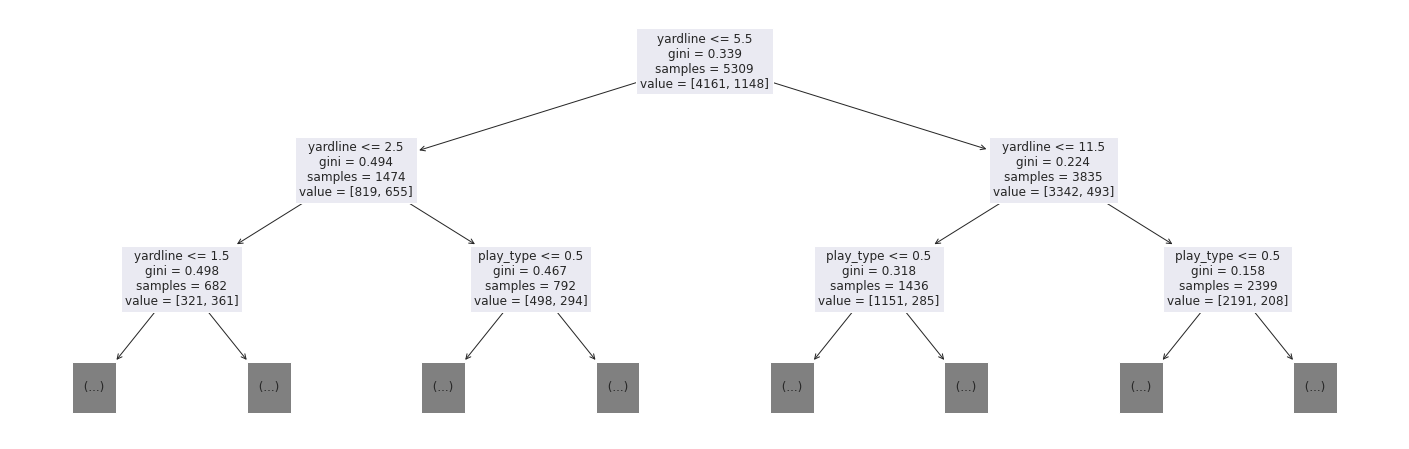

In [107]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Setup the independent variables(predictors), and dependent variables(correct answers)
ind = []
dep = []
for index, val in mlData.iterrows():
    ind.append([val.yardline_100, (1 if val.play_type == 'pass' else 0), val.shotgun, val.down, (1 if val.posteam_type == 'home' else 0)])
    dep.append(val.touchdown)

# Make the model
dt = DecisionTreeClassifier()

# Train the model
dt.fit(ind, dep)

# Display the first two layers of the decision tree
fig, ax = plt.subplots(figsize=(25, 8))
tree.plot_tree(dt, max_depth=2, fontsize=12, feature_names=['yardline', 'play_type', 'shotgun', 'down', 'posteam'])
plt.show()

<ipython-input-97-59d04cd5c984>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlData["predicted"] = dt.predict(ind)


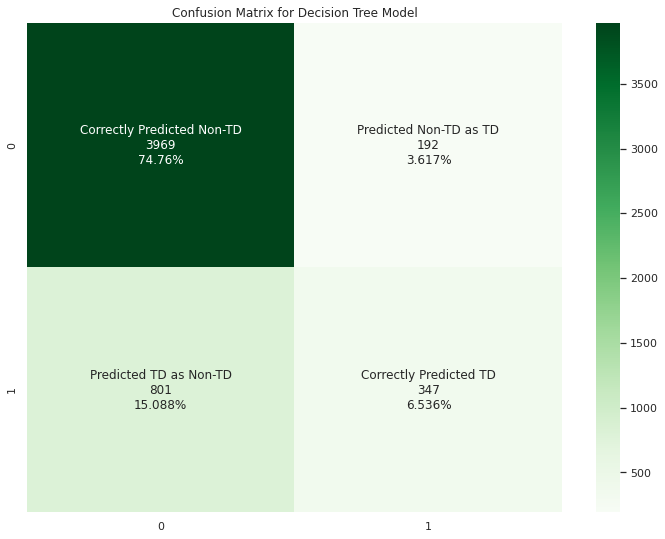

In [97]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

# Add the predictions to the dataset
mlData["predicted"] = dt.predict(ind)

# Make the confusion matrix
confuse = confusion_matrix(mlData.touchdown, mlData.predicted)

# Make labels for the confusion matrix
categories = ["Correctly Predicted Non-TD", "Predicted Non-TD as TD", "Predicted TD as Non-TD", "Correctly Predicted TD"]
labels = np.asarray([f"{name}\n{number}\n{percentage}%" for name, number, percentage in zip(categories, confuse.flatten(), [round(i*100/len(mlData), 3) for i in confuse.flatten()])]).reshape(2,2)

# Plot the confusion matrix
fig, ax = plt.subplots()

# Style
ax.set_title('Confusion Matrix for Decision Tree Model')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

sn.heatmap(confuse, annot=labels, fmt='', cmap='Greens');

fig.set_figwidth(12)
fig.set_figheight(9)

In [93]:
# Making a function to plot the confusion matrix for any given season
def test_model(model, year, ax):
    # Get the data
    testData = pd.read_csv(f'https://github.com/nflverse/nflfastR-data/blob/master/data/play_by_play_{year}.csv.gz?raw=True', compression='gzip',low_memory=False)

    # Select only the rows and columns that we care about
    testData = testData[testData.yardline_100 <= 20]
    testData = testData[((testData.play_type == "pass") | (testData.play_type == "run")) & (testData.two_point_attempt == 0)]
    testData = testData[["play_id", "yardline_100", "play_type", "ydsnet", "shotgun", "posteam_type", "down", "touchdown"]]

    # Wrangle the data so that the independent variables are our predictors
    testInd = []
    for index, val in testData.iterrows():
        testInd.append([val.yardline_100, (1 if val.play_type == 'pass' else 0), val.shotgun, val.down, (1 if val.posteam_type == 'home' else 0)])

    # Add the predictions to the dataframe
    testData["predicted"] = model.predict(testInd)

    # Make the confusion matrix
    confuse = confusion_matrix(testData.touchdown, testData.predicted)

    # Make the labels
    categories = ["Correctly Predicted Non-TD", "Predicted Non-TD as TD", "Predicted TD as Non-TD", "Correctly Predicted TD"]
    labels = np.asarray([f"{name}\n{number}\n{percentage}%" for name, number, percentage in zip(categories, confuse.flatten(), [round(i*100/len(mlData), 3) for i in confuse.flatten()])]).reshape(2,2)

    # Make the plot
    # Style
    ax.set_title(f'Confusion Matrix for Decision Tree Model - {year} Season')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')

    sn.heatmap(confuse, annot=labels, fmt='', cmap='Greens', ax = ax);

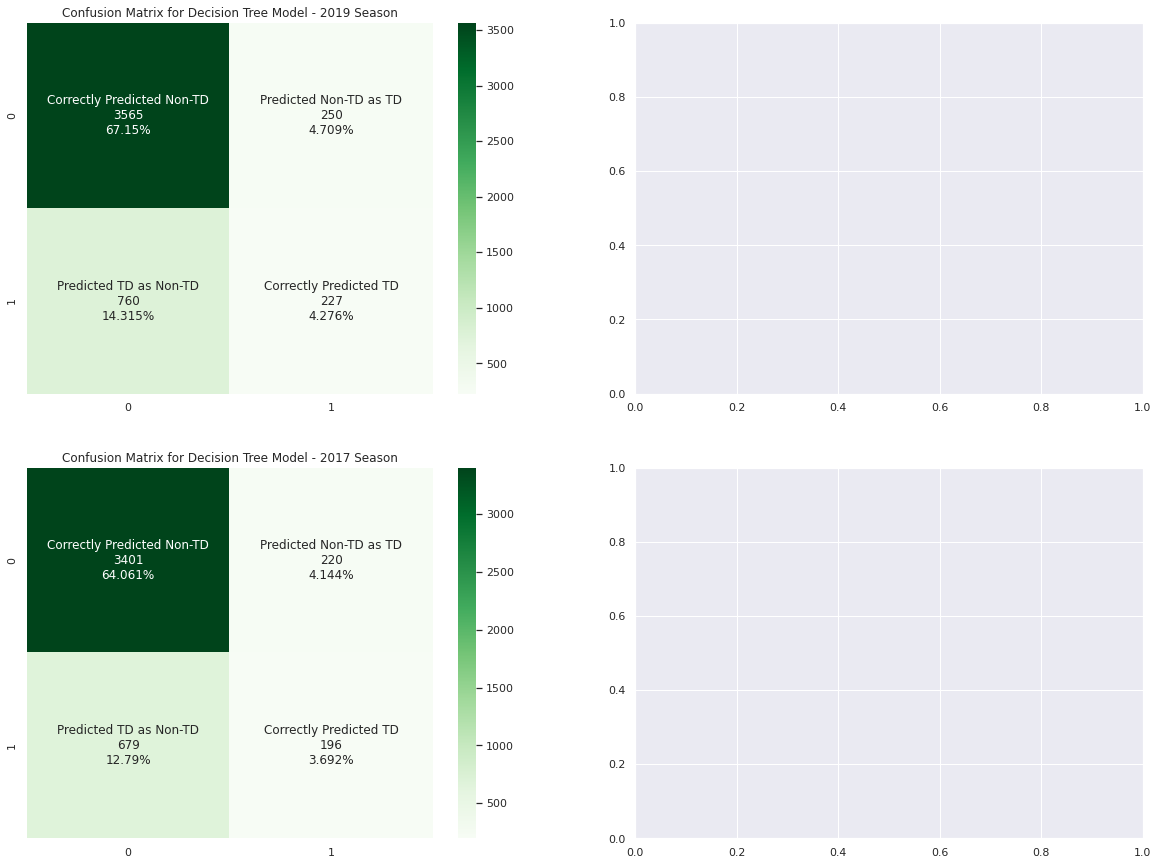

In [95]:
# Test the model on 2016-2019
fig, axs = plt.subplots(2,2)
test_model(dt, "2019", axs[0,0])
test_model(dt, "2018", axs[0,1])
test_model(dt, "2017", axs[1,0])
test_model(dt, "2016", axs[1,1])

# Make the plots larger
fig.set_figwidth(25)
fig.set_figheight(18)

# OLD STUFF

In order to perform machine learning on this dataset, we need to select a [*loss function*](https://en.wikipedia.org/wiki/Loss_function). A loss function is what the machine learning algorithm will attempt to minimize. In our case, our loss function will be based on the number of **correctly classified plays**. Our goal is to *minimize* the number of **incorrectly classified plays**. This is called [0-1 loss](https://stats.stackexchange.com/questions/284028/0-1-loss-function-explanation/284062). This is a poor loss function because it is discontinuous, which means that our machine learning algorithm could get stuck at a point where it does not know which direction to iterate in. For this reason, we will be using a [squared loss function](http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/lossfunctions/SquaredLoss.pdf). The squared loss function is nice because it "slopes" down into the correct prediction value. I am not going to go in-depth about loss functions for this tutorial, but if you have questions, I recommend reading the links in this paragraph, or searching for more information yourself.

In [13]:
# Make dummy variables for play type and home vs away team
mlData = pd.get_dummies(mlData)
mlData.head()

,play_id,yardline_100,ydsnet,shotgun,down,touchdown,play_type_pass,play_type_run,posteam_type_away,posteam_type_home
26,700,10.0,10.0,0,1.0,1.0,1,0,1,0
43,1144,19.0,61.0,0,2.0,0.0,0,1,0,1
45,1184,10.0,61.0,0,1.0,0.0,0,1,0,1
47,1228,12.0,61.0,1,2.0,0.0,1,0,0,1
48,1247,17.0,61.0,1,3.0,0.0,0,1,0,1


0.12357873584238865


<AxesSubplot:xlabel='touchdown', ylabel='predictions'>

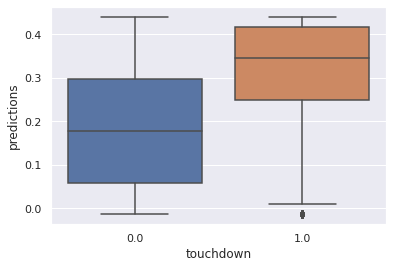

In [21]:
# Import necessary libraries
from sklearn import linear_model
from sklearn.metrics import r2_score

ind = []
dep = []
for index, val in mlData.iterrows():
    ind.append([val.yardline_100])
    dep.append(val.touchdown)

lm = linear_model.LinearRegression()
lm.fit(ind,dep)

mlData["predictions"] = lm.predict(ind)

fig, ax = plt.subplots()

# Print the r-squared value
print(r2_score(mlData.touchdown, mlData.predictions))

sn.boxplot( x=mlData["touchdown"], y=mlData["predictions"], ax=ax)

In [31]:
lm.coef_

array([-0.02433002,  0.00141522,  0.0411067 , -0.0411067 ])

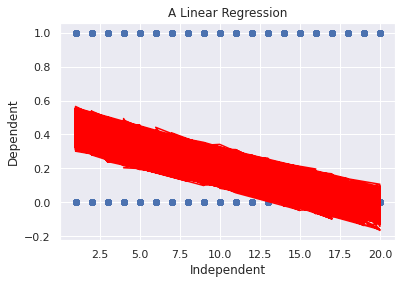

In [15]:
fig, ax = plt.subplots()

just_data = [i[0] for i in ind]
ax.scatter(just_data, dep)
ax.set_xlabel("Independent")
ax.set_ylabel("Dependent")
ax.set_title("A Linear Regression")
    
ax.plot(just_data, lm.predict(ind), color='red')

In [16]:
dep[38]

1.0

## Conclusions

We have learned a lot from this data set. We were able to store the data in pandas, and manipulate it to better reveal the information that we are interested in. In the exploratory data analysis section we were able to break down the input data by team, and count the number of run and pass plays that were called by each team in the red zone. Then, we plotted the data using Matplotlib and seaborn to make graphs that helped us intuitively determine that there was a linear relationship between distance from the end zone and probability of scoring a touchdown on a given play. We were then able to verify this intuition with math by performing a hypothesis test

learned that New England Patriots tend to run the ball much more than they pass the ball in the red zone, while the Houston Texans and Jacksonville Jaguars tend to pass the ball more than they run the ball in the red zone overall.